In [24]:
library(anndata)
library(Signac)
library(Seurat)
library(anndata)
library(ggplot2)
library(tidyverse)

In [2]:
library(Signac)
library(Seurat)
#library(EnsDb.Mmusculus.v102)
library(BSgenome.Mmusculus.UCSC.mm10)
#library(pastecs)
library(stringr)

Lade nötiges Paket: BSgenome

Lade nötiges Paket: BiocGenerics


Attache Paket: ‘BiocGenerics’


Die folgenden Objekte sind maskiert von ‘package:stats’:

    IQR, mad, sd, var, xtabs


Die folgenden Objekte sind maskiert von ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Lade nötiges Paket: S4Vectors

Lade nötiges Paket: stats4


Attache Paket: ‘S4Vectors’


Die folgenden Objekte sind maskiert von ‘package:base’:

    I, expand.grid, unname


Lade nötiges Paket: IRanges


Attache Paket: ‘IRanges’


Das folgende Objekt ist maskiert ‘package:sp’:

    %over%


Lade nötiges Paket: GenomeInfoDb

Lade nötiges Paket: GenomicRanges

L

In [3]:
seurat <- readRDS("/Users/dominik.klein/data/E14-E15_adata_filtered_seurat_merged_peaks.rds")

In [4]:
adata <- read_h5ad("/Users/dominik.klein/data/endocrine_refinement.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 16918 × 14663
    obs: 'n_counts', 'sample', 'int_id', 'reporter', 'log_cell_probs', 'cell_barcodes_du', 'cell_barcodes_cr', 'cell_barcodes', 'log_counts', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'total_counts_rank', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'log_nCount_ATAC', 'log_nFeature_ATAC', 'scrublet_scores', 'scrublet_doublets', 'scrublet_doublets_cat', 'dd_doublets', 'dd_scores', 'dd_log_p_values', 'dd_voting_average', 'dd_-log_p_values', 'dd_doublets_cat', 'pANN', 'DF_classifications_1', 'DF_classifications_2', 'pANN_SCT', 'DF_SCT_classifications_1', 'DF_SCT_classifications_2', 'df_doublets',

In [6]:
adata$obs$index_name <- rownames(adata$obs)

In [7]:
adapt_obs_names <- function(x){
    tmp <- str_split(x, "-")[[1]]
    if(tmp[3] == "0"){
        prefix <- "E14-5"
        }
    else{
        prefix <- "E15-5"
        }
    return(paste(prefix, "_", tmp[1], "-", tmp[2], sep = ""))
    }

In [8]:
adata$obs$obs_name_adapted <- sapply(adata$obs$index_name, adapt_obs_names)

In [9]:
seurat <- seurat[,adata$obs$obs_name_adapted]

In [10]:
seurat

An object of class Seurat 
475329 features across 16918 samples within 3 assays 
Active assay: ATAC_merged (228259 features, 228259 variable features)
 2 other assays present: RNA, ATAC
 1 dimensional reduction calculated: lsi

In [11]:
seurat@meta.data$rowname <- rownames(seurat@meta.data)

In [12]:
merged_obs <- merge(seurat@meta.data, adata$obs, by.x="rowname", by.y="obs_name_adapted")

In [13]:
seurat@meta.data <- merged_obs

In [14]:
seurat

An object of class Seurat 
475329 features across 16918 samples within 3 assays 
Active assay: ATAC_merged (228259 features, 228259 variable features)
 2 other assays present: RNA, ATAC
 1 dimensional reduction calculated: lsi

In [15]:
# extract gene annotations from EnsDb
#annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Mmusculus.v102)

# rename chromosome names to match cellranger output
BSgenome.Mmusculus.UCSC.mm10.renamed <- renameSeqlevels(BSgenome.Mmusculus.UCSC.mm10, value = str_replace(str_replace(seqnames(BSgenome.Mmusculus.UCSC.mm10), pattern = "chr", replacement = ""), pattern = "M", replacement = "MT"))

In [16]:
seurat

An object of class Seurat 
475329 features across 16918 samples within 3 assays 
Active assay: ATAC_merged (228259 features, 228259 variable features)
 2 other assays present: RNA, ATAC
 1 dimensional reduction calculated: lsi

In [17]:
seurat <- RegionStats(seurat, genome = BSgenome.Mmusculus.UCSC.mm10.renamed)

In [18]:
# general endocrine (progenitor) markers
c1 <- c("Fev", "Gcg", "Ghrl", "Ins2", "Pyy")
# delta markers
c2 <- c("Hhex", "Sst", "Cd24a", "Rbp4") 
# Cellrank delta markers
c3 <- c("Hadh", "Isl1", "Pkhd1", "Map2k4", "Msi1", "Nefl")

c <- c(c1, c2, c3)

In [19]:
seurat <- LinkPeaks(
  object = seurat,
  peak.assay = "ATAC_merged",
  expression.assay = "RNA",
  genes.use = c
)

Testing 15 genes and 228257 peaks



In [264]:
get_link_ranges <- function(object, assay, gene, n_links=0, upstream=0.05, downstream=0.05, smooth.spline.spar=0.65){
  # Gets the entire range of the n_links top peak-gene links of a given gene and the gene itself
  # object = seurat object
  # assay = ATAC/Peaks assay with links and annotation
  # gene = Gene for which links should be found
  # n_links = number of links to be included. If 0, estimate number of top links.
  # upstream/downstream = number of bases to add up/downstream. If < 1: defines the fraction of the total length that is added.
  
  # TO DO: score cut-off (abs scores)
  #detach("package:MOFA2", unload = TRUE)
  
  # get links for gene
  links_df <- as.data.frame(object[[assay]]@links[object[[assay]]@links$gene==gene])
  if (length(object[[assay]]@links[object[[assay]]@links$gene==gene]) == 0){
      print("No links detected for this gene")
      }
  links_df$abs_score <- abs(links_df$score)
  links_df <- links_df[order(links_df$abs_score, decreasing = TRUE),]
  links_df$rank <- seq(1,nrow(links_df))
  
  if (n_links == 0){
    # estimate top links
    model <- smooth.spline(x = links_df$rank, y = links_df$abs_score, spar = smooth.spline.spar)
    n_links <- which.max(stats::predict(model,  deriv = 2)$y)
  } 
  
  # get gene ranges
  gene_ranges <- data.frame(object[[assay]]@annotation@ranges[which(object[[assay]]@annotation$gene_name==gene)])[,c("start","end")]
  
  # get link ranges
  link_ranges <- links_df[1:n_links,c("start","end")]
  
  # get merge ranges
  ranges <- rbind(gene_ranges, link_ranges)
  
  chr <- links_df$seqnames[1]
  start <- min(ranges$start)
  end <- max(ranges$end)
  
  # add up/downstream ranges
  width <- end - start
  
  if (downstream < 1){
    downstream <- as.integer(width*downstream)
  }
  
  if (upstream < 1){
    upstream <- as.integer(width*upstream)
  }
  
  start <- start - upstream
  end <- end + downstream
  
  #plot link scores
  print(ggplot(links_df, aes(x=rank, y=abs_score)) + geom_point(color="firebrick") + geom_vline(xintercept = n_links, linetype=2) + labs(x="Rank", y="Absolute Score", title=paste0("Top Links (",n_links,")")))
  
  # return
  final_range <- GenomicRanges::GRanges(seqnames = chr, ranges = IRanges(start, end))
  final_range$gene <- gene
  return(list(final_range, links_df))
  # return(list("chr"=chr, 
  #                   "start"=start,
  #                   "end"=end,
  #                   "gene"=gene))
} 

In [265]:
get_results <- function(object, ident, gene, n_links=2, downstream=0.2, assay="ATAC_merged"){
    Idents(object) <- ident
    res <- get_link_ranges(object = object, assay = assay, gene = gene, n_links = n_links, downstream = downstream)
    range <- res[[1]]
    
    coverage <- CoveragePlot(
      object = seurat,
      region = range,
      features = range$gene,
      expression.assay = "RNA",
      annotation = FALSE,
      peaks = FALSE,
      links = FALSE
    )
    
    anno <- AnnotationPlot(object = seurat, region = range)

    #peaks <- PeakPlot(object = seurat, region = range, group.by = "count") + scale_color_gradient("Counts", low = "gray85", high = "black")
    peaks <- PeakPlot(object = seurat, region = range, color = "black") 

    links <- LinkPlot(object = seurat, region = range)  + scale_color_gradient2(low = "#d8002d", mid = "gray95",high = "#0075d7", midpoint = 0)#+ scale_color_viridis_c("Score",option = "mako", begin = 0.25, end = 1, direction = -1) #

    expression <- ExpressionPlot(
      object = seurat,
      features = range$gene,
      assay = "RNA"
    )

    combined <- CombineTracks(
      plotlist = list(coverage, anno, peaks, links),
      expression.plot = expression, 
      heights = c(8, 2, 1, 3),
      widths = c(18, 2)
    )

    print(combined)
    
    for (i in c(1:n_links)){
        feature <- res[[2]]$peak[i]
        counts <- as.vector(seurat[feature,][[assay]]@data)
        celltype <- seurat@meta.data[ident]
        data <- data.frame(counts, celltype)

        p <- ggplot(as_tibble(data), aes(factor(split_fev_delta), counts)) + 
        geom_violin() + 
        geom_boxplot(width=.1) + 
        labs(title = feature, x = "cluster", y = "normalized counts") + 
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
        print(p)
    }
    }
    
    

## General endocrine markers

In [266]:
get_results(seurat, "split_fev_delta", "Ghrl")

[1] "No links detected for this gene"


ERROR: Error in `$<-.data.frame`(`*tmp*`, "rank", value = 1:0): Ersetzung hat 2 Zeilen, Daten haben 0


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



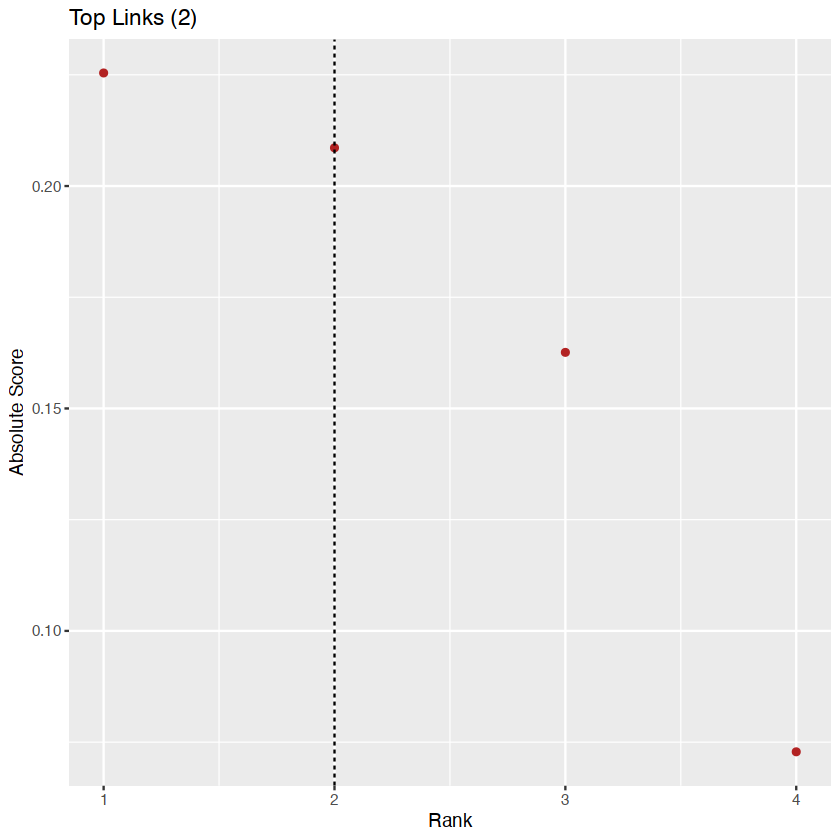

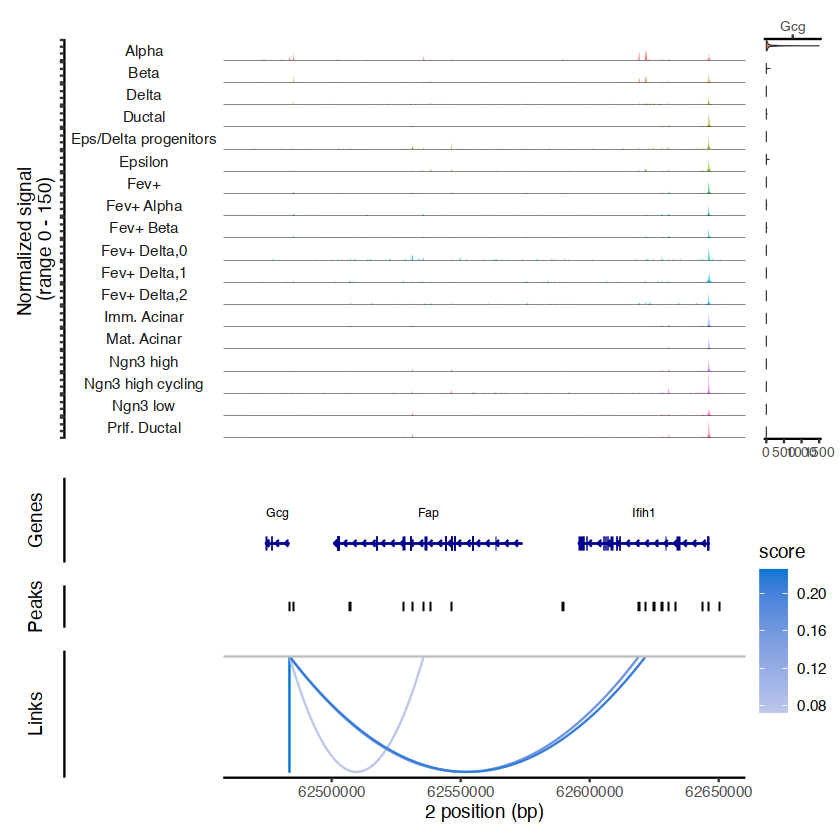

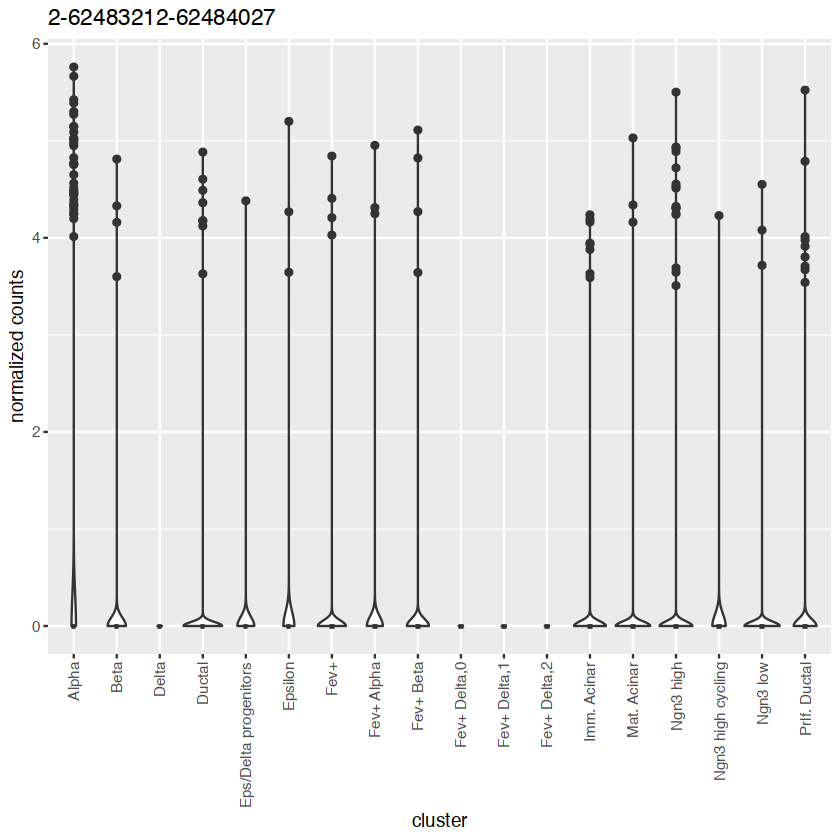

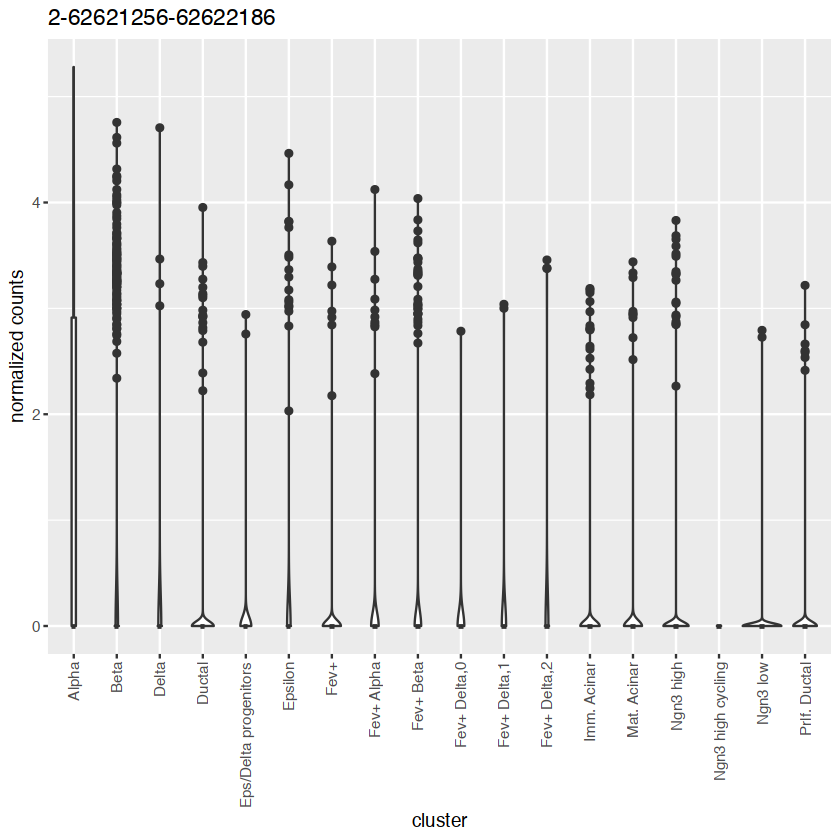

In [267]:
get_results(seurat, "split_fev_delta", "Gcg")

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



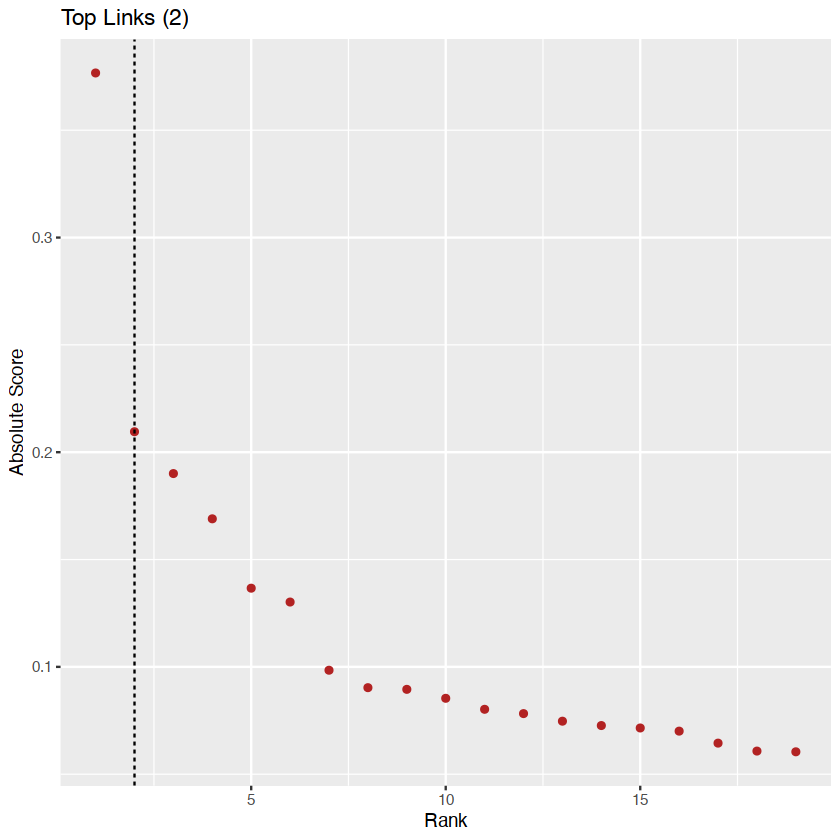

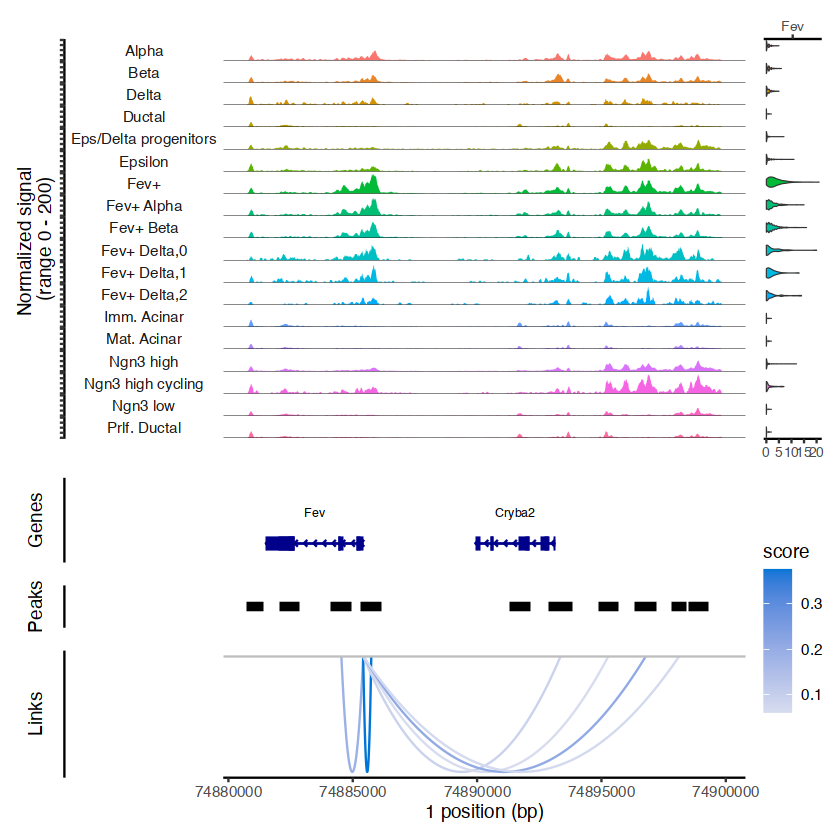

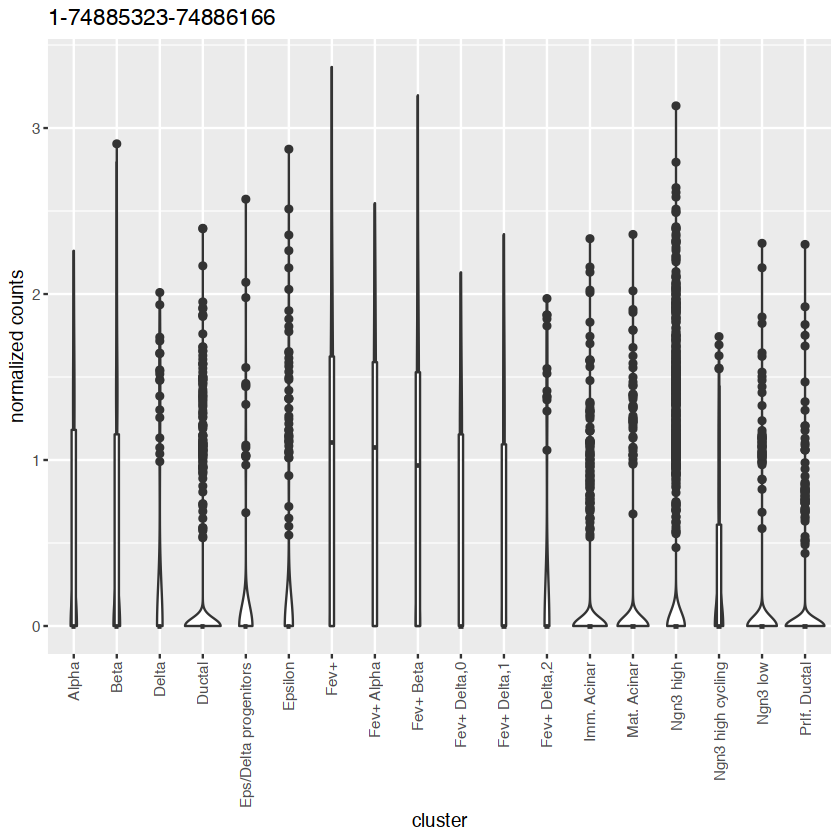

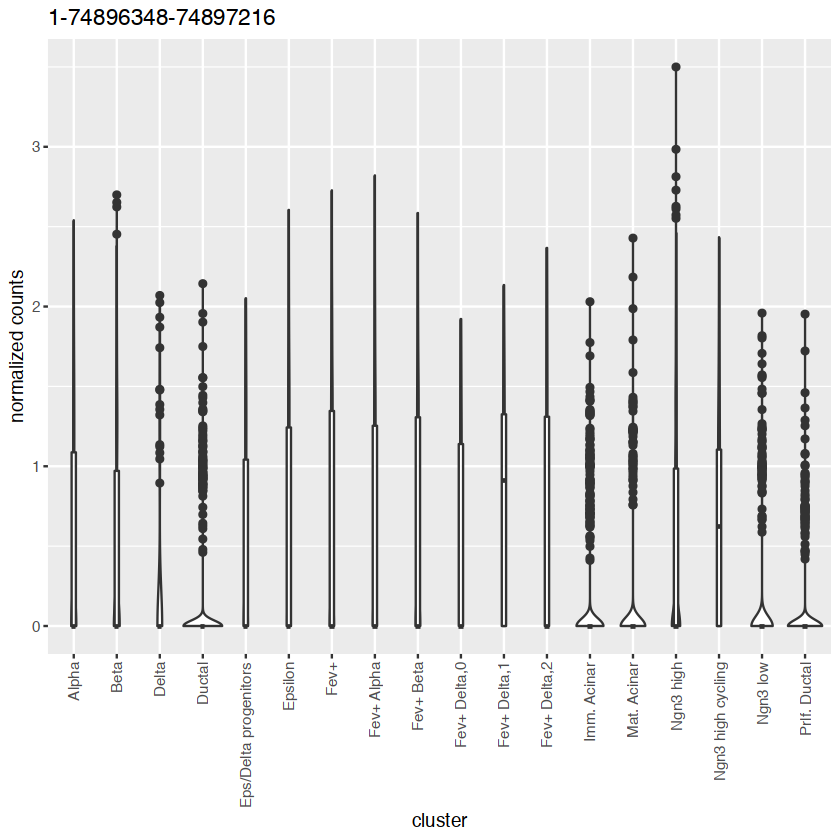

In [268]:
get_results(seurat, "split_fev_delta", "Fev")

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Warning message:
“Removed 55 rows containing missing values (geom_segment).”


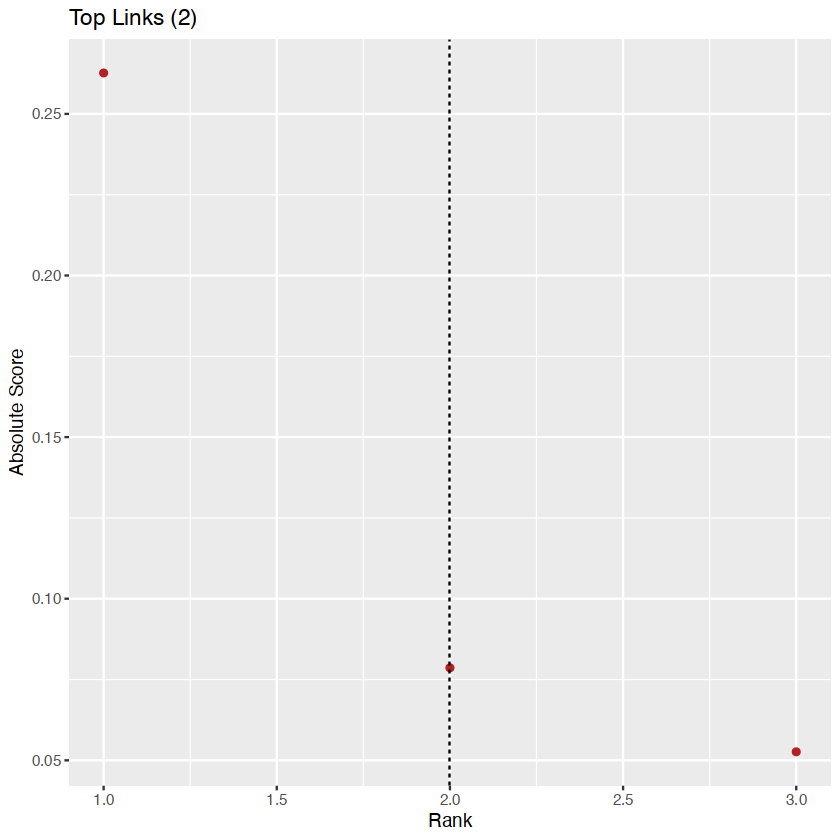

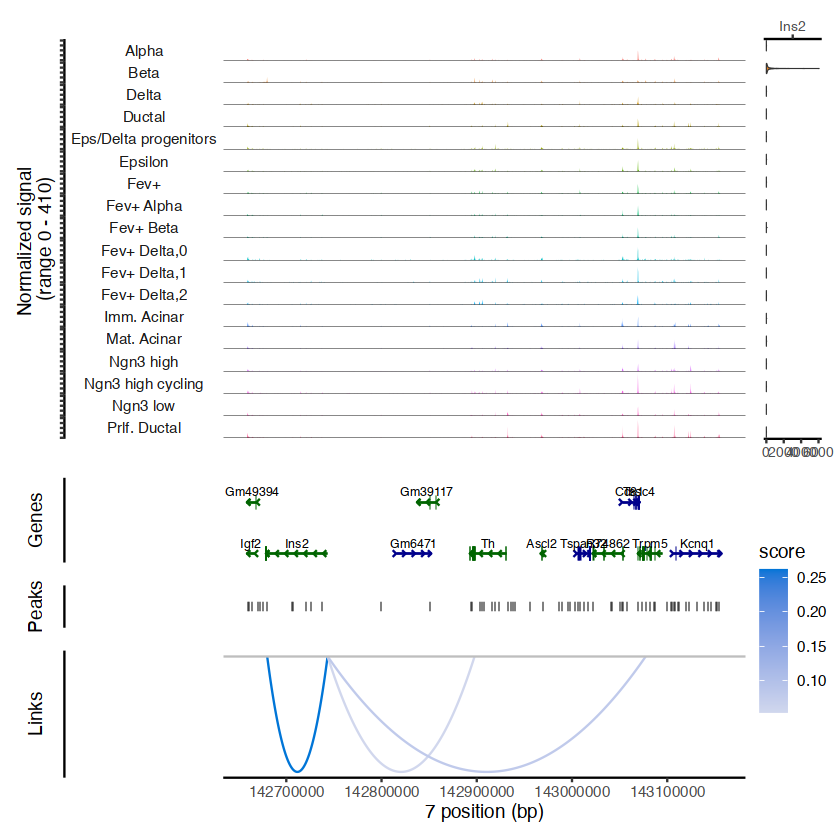

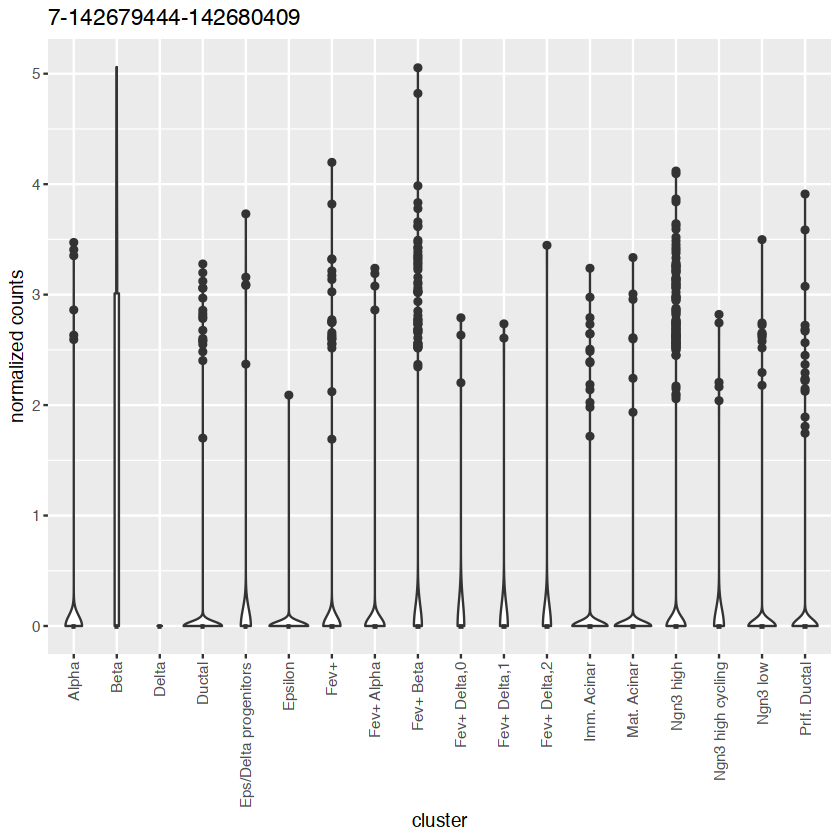

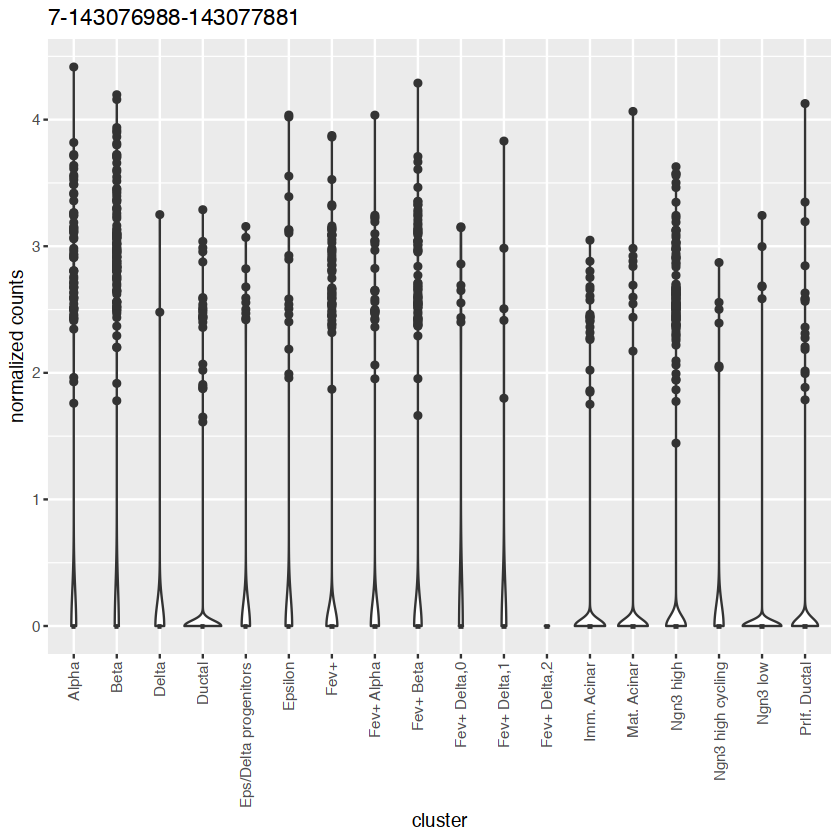

In [269]:
get_results(seurat, "split_fev_delta", "Ins2")

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Warning message:
“Removed 32 rows containing missing values (geom_segment).”


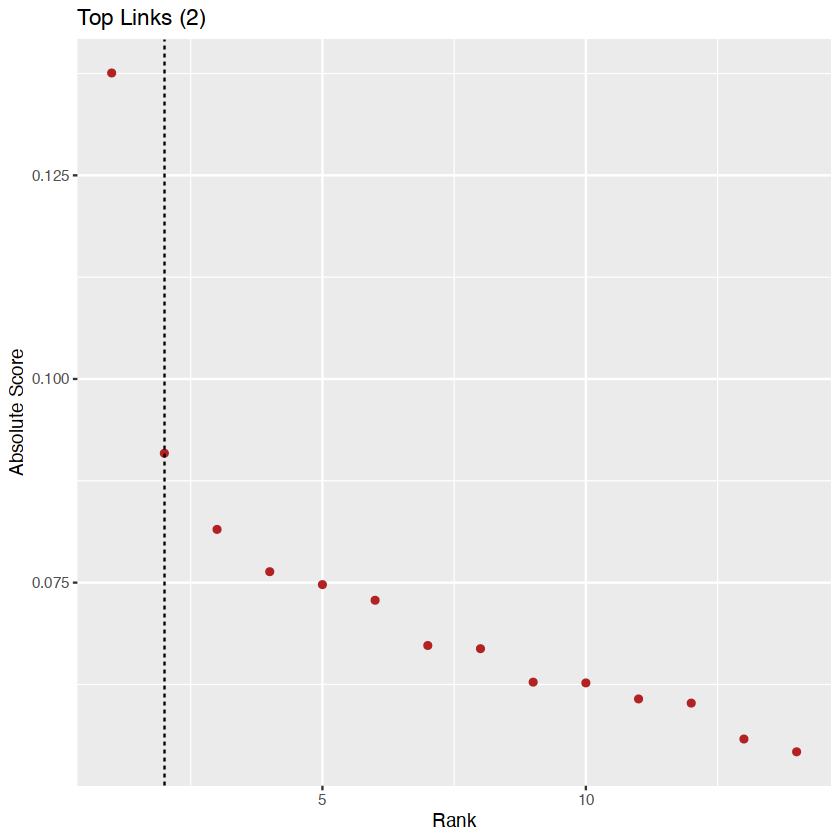

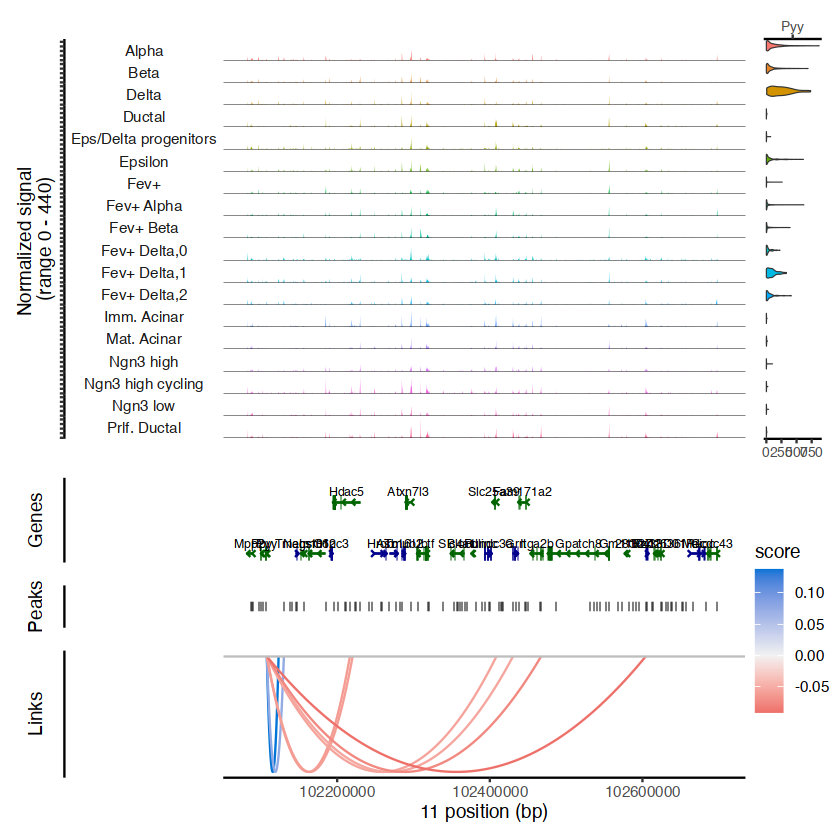

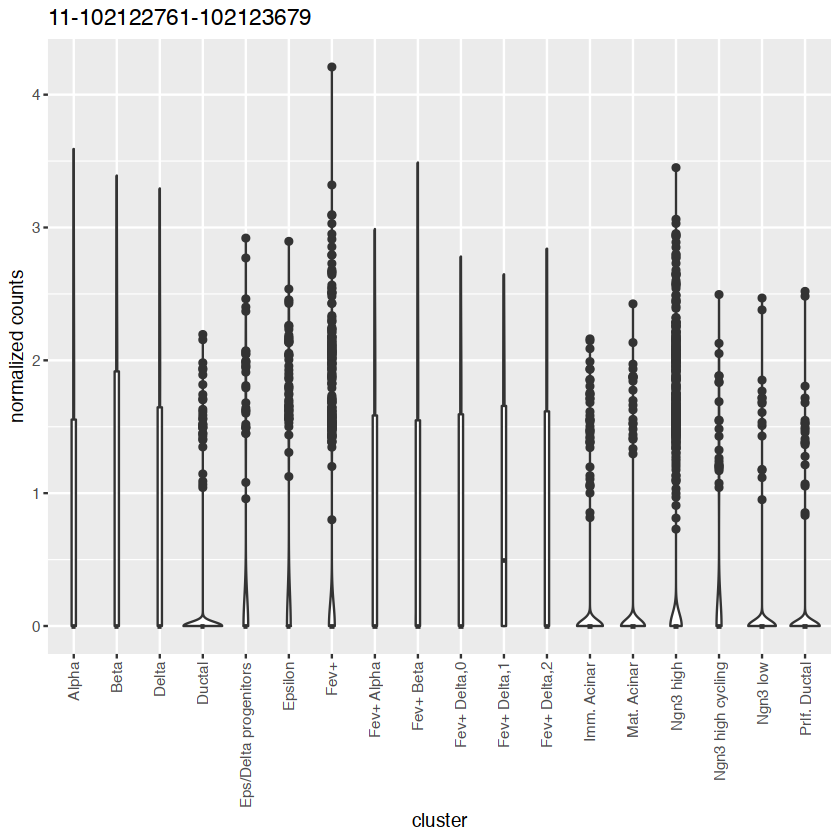

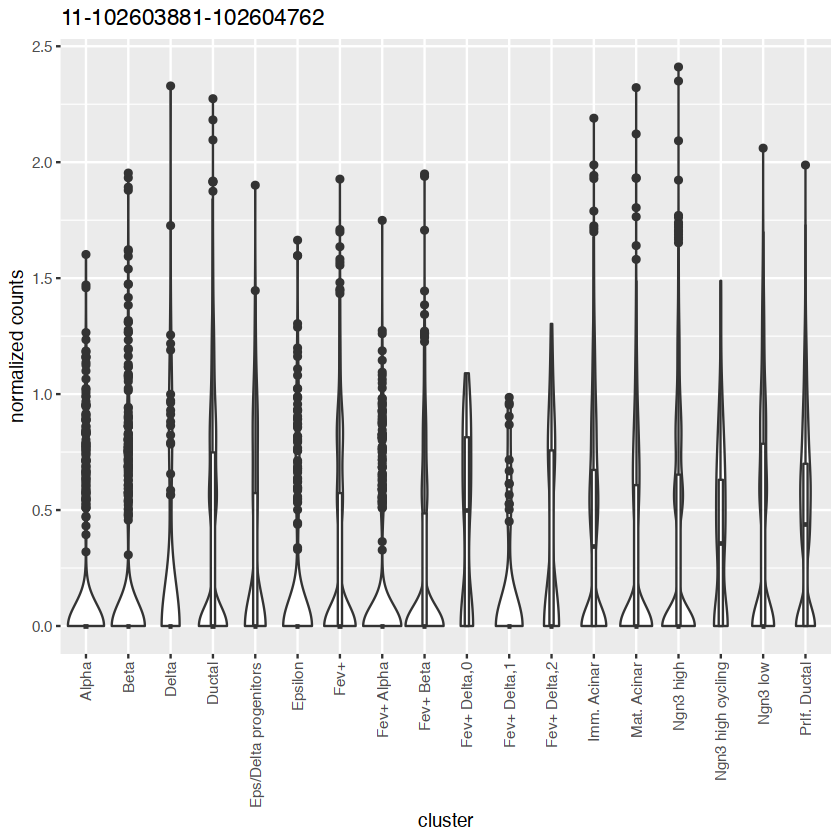

In [270]:
get_results(seurat, "split_fev_delta", "Pyy")

## Delta markers

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



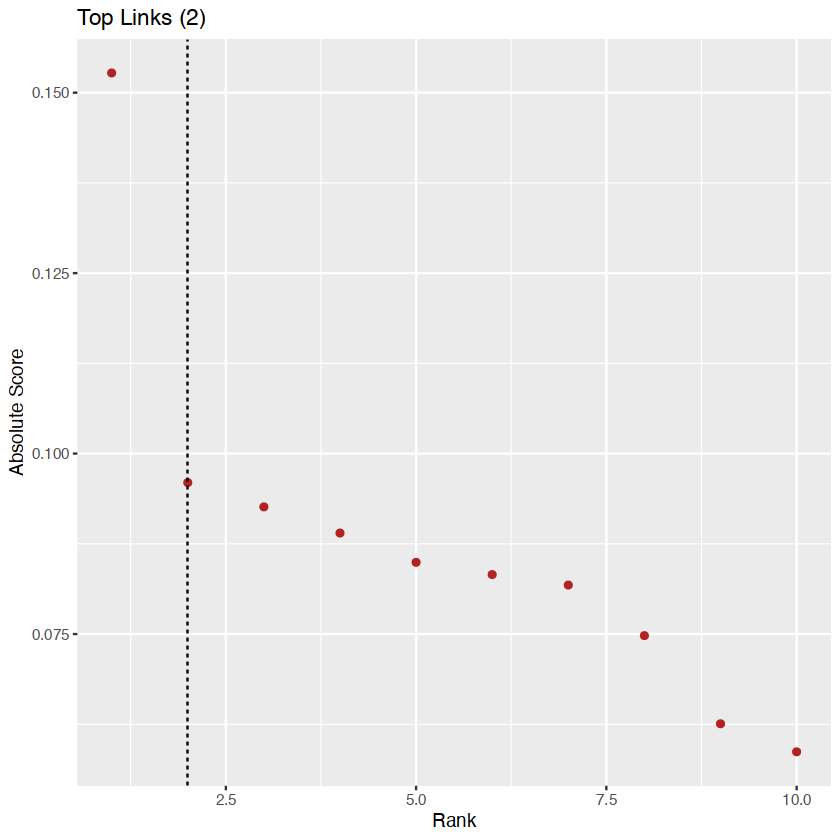

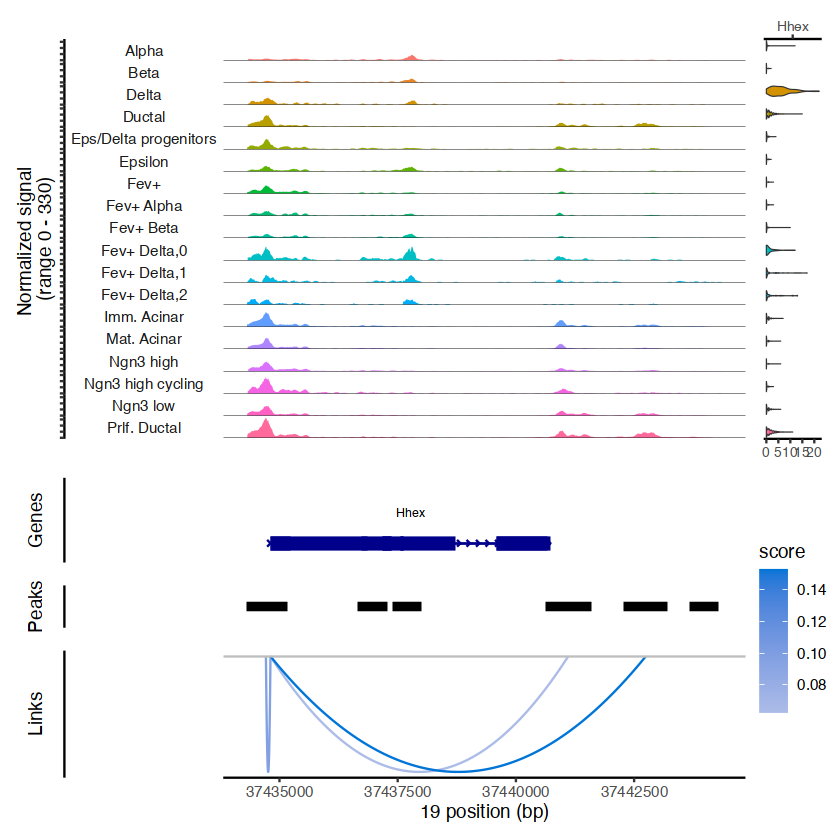

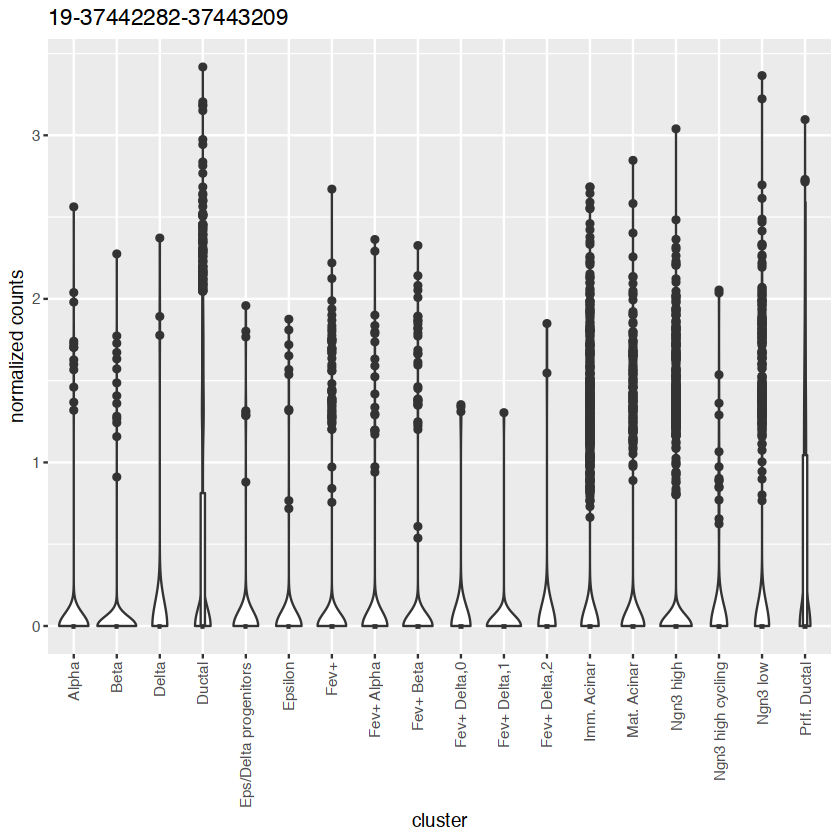

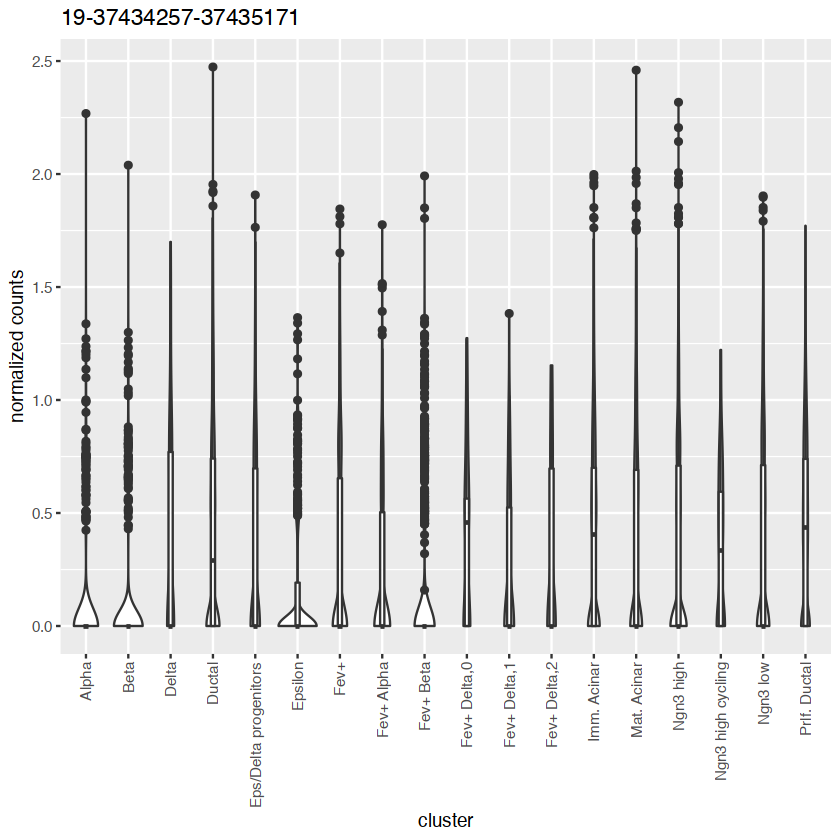

In [271]:
get_results(seurat, "split_fev_delta", "Hhex")

ERROR: Error in .new_IRanges_from_start_end(start, end): 'start' or 'end' cannot contain NAs


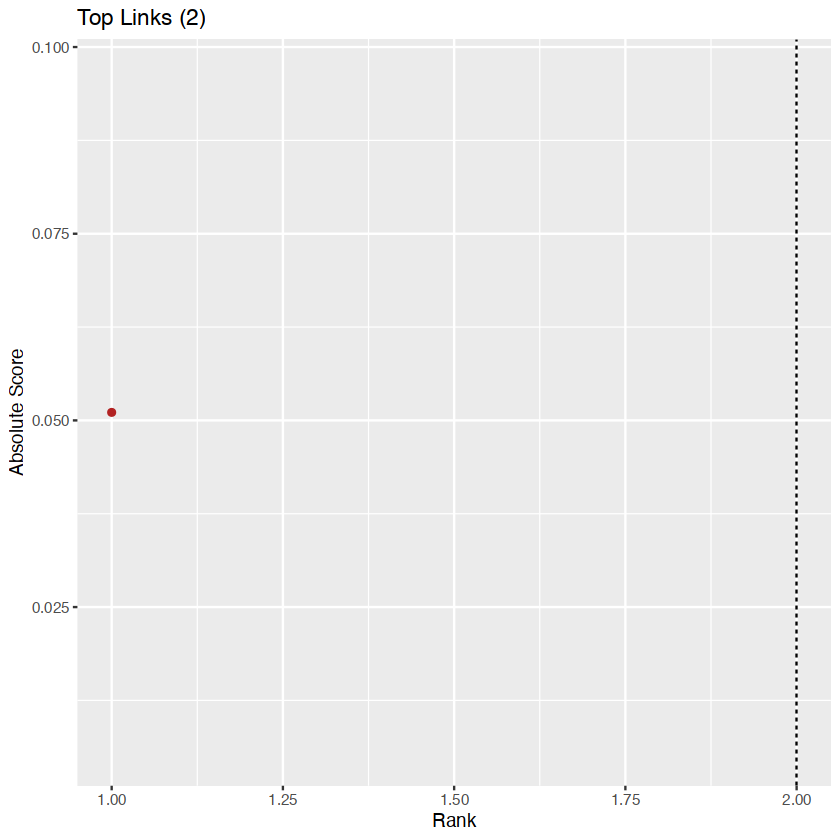

In [272]:
get_results(seurat, "split_fev_delta", "Sst")

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Warning message:
“Removed 2 rows containing missing values (geom_segment).”


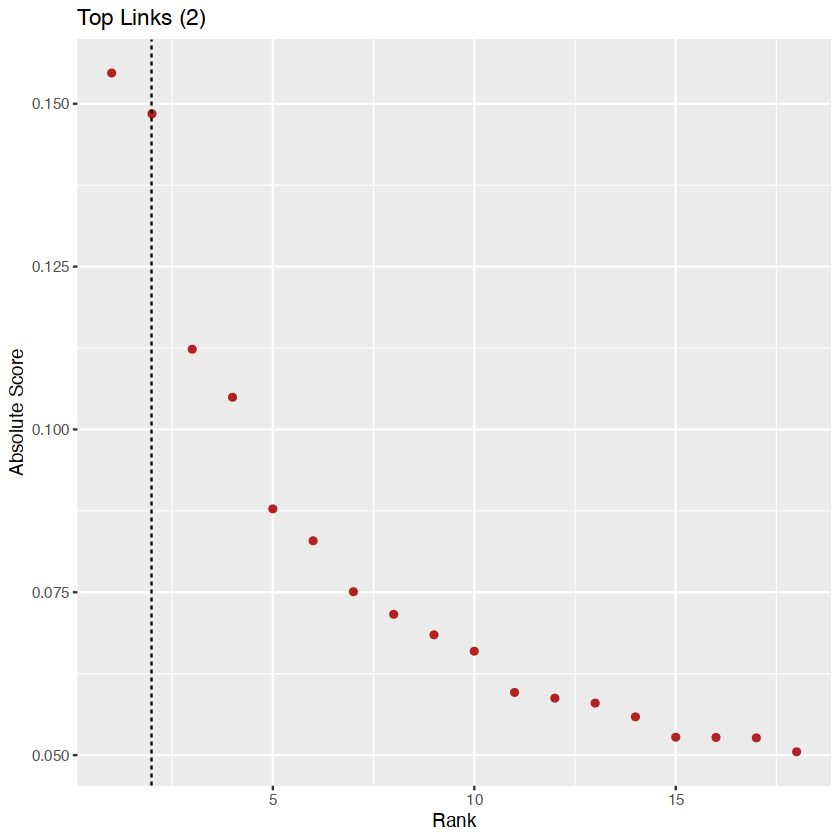

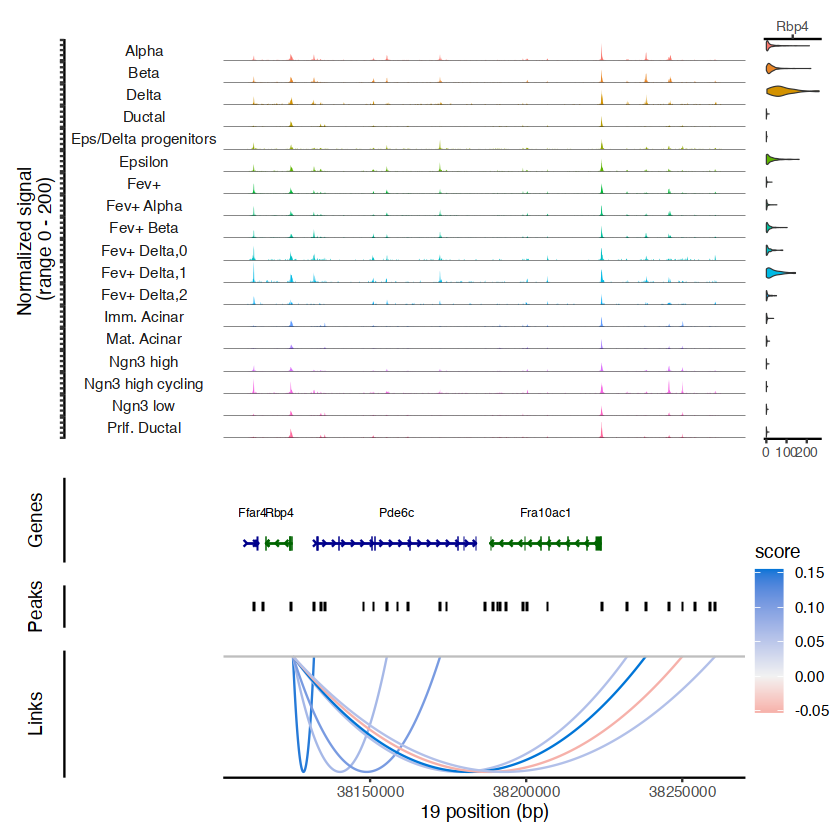

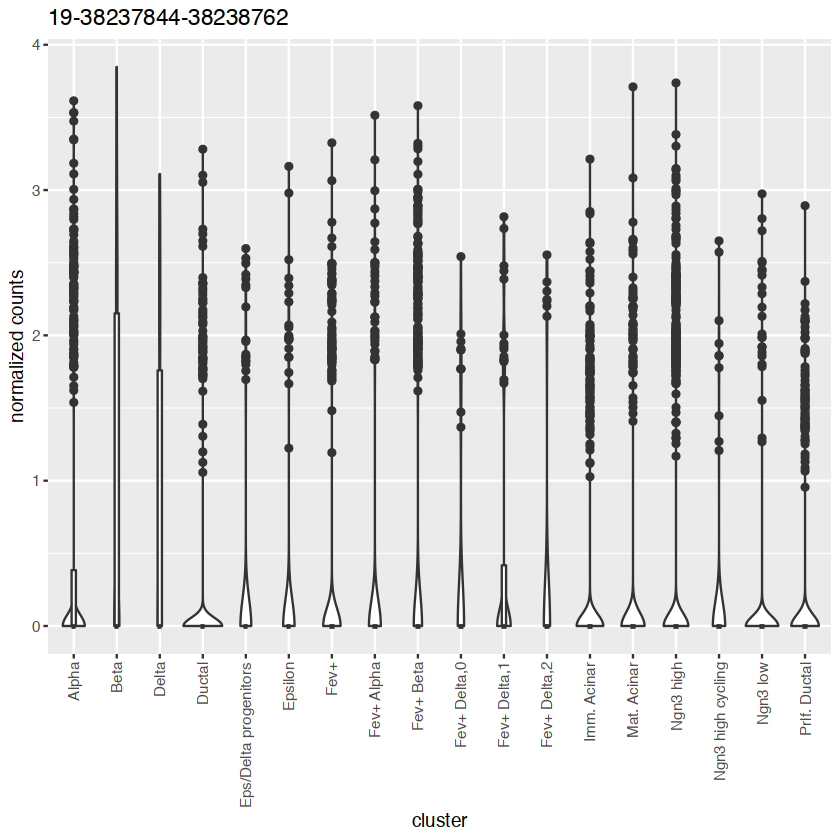

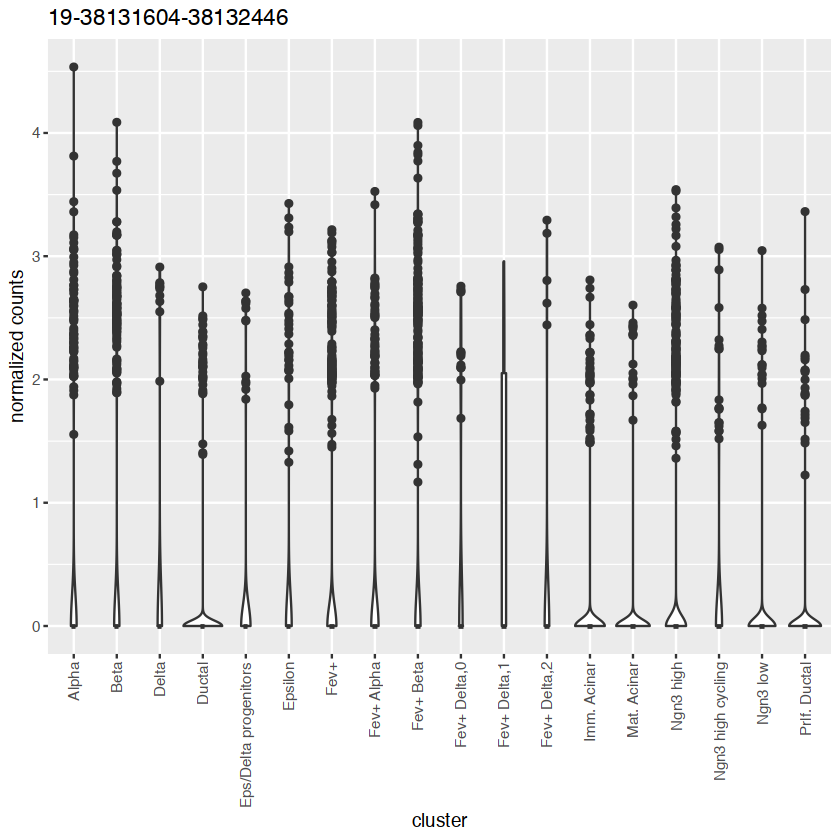

In [273]:
get_results(seurat, "split_fev_delta", "Rbp4")

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Warning message:
“Removed 37 rows containing missing values (geom_segment).”


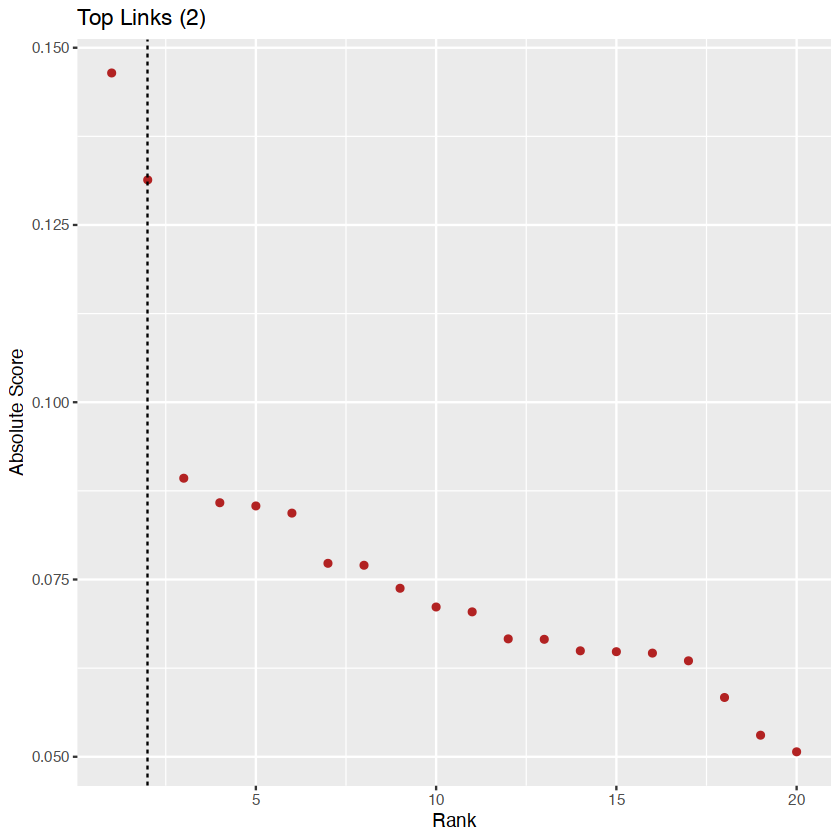

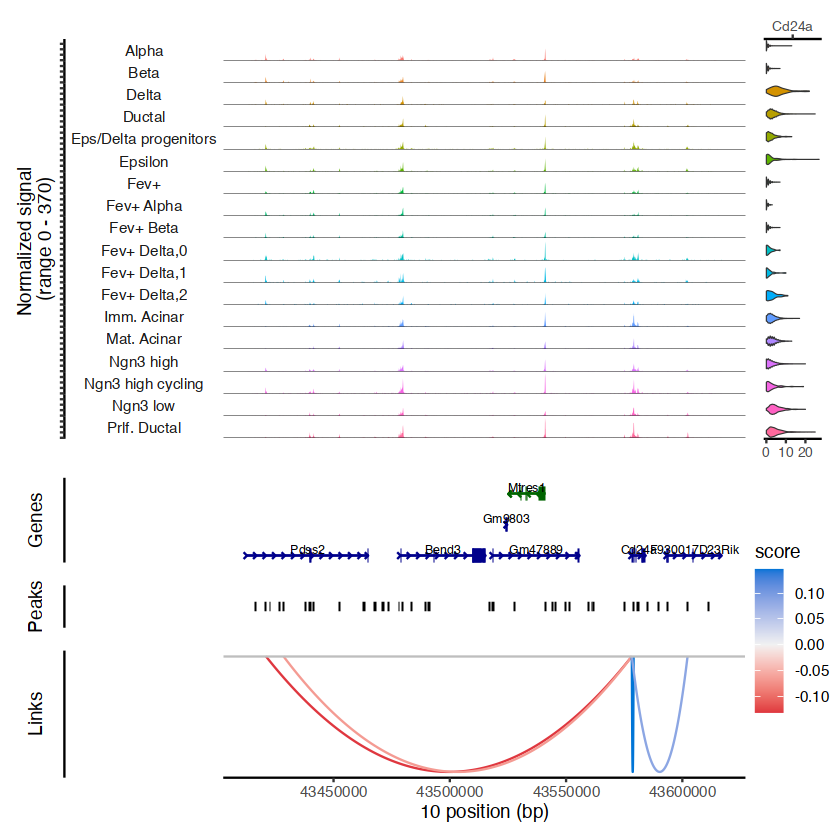

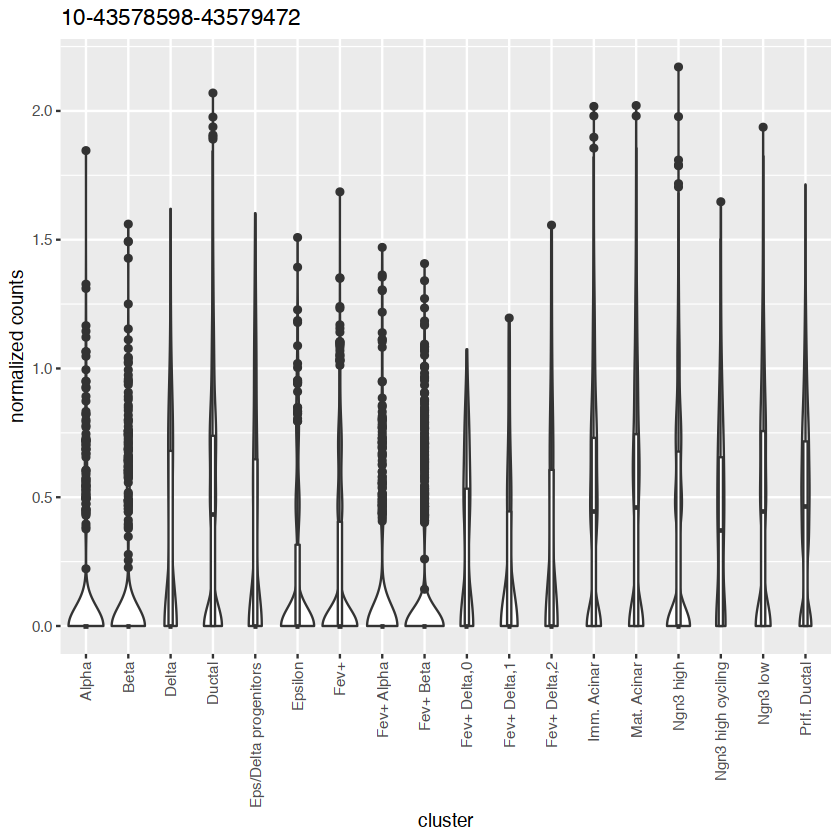

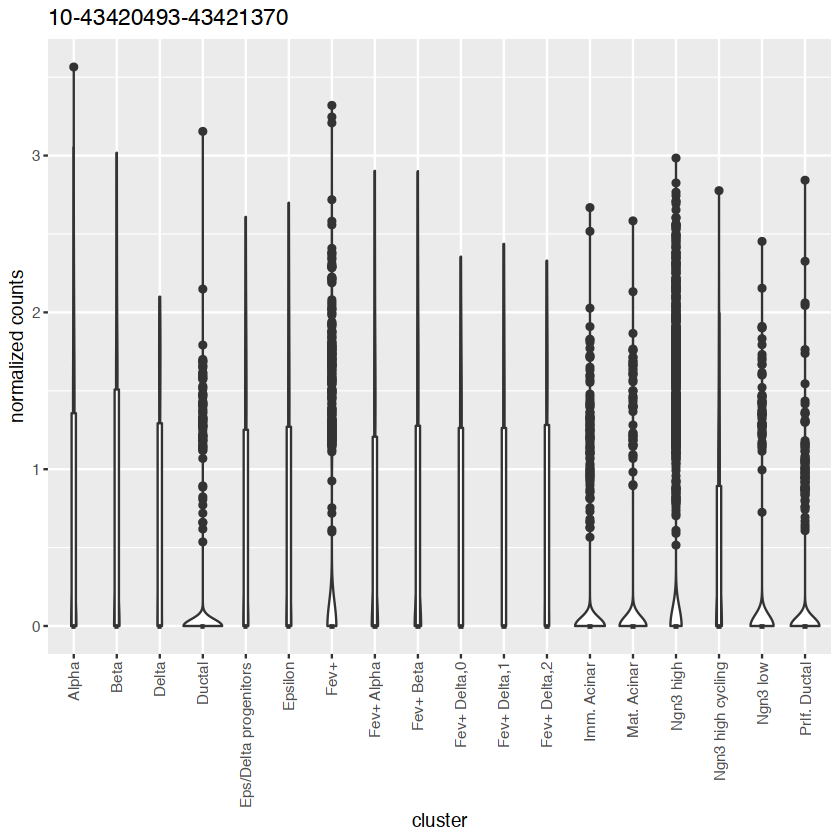

In [274]:
get_results(seurat, "split_fev_delta", "Cd24a")

## CellRank delta markers

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



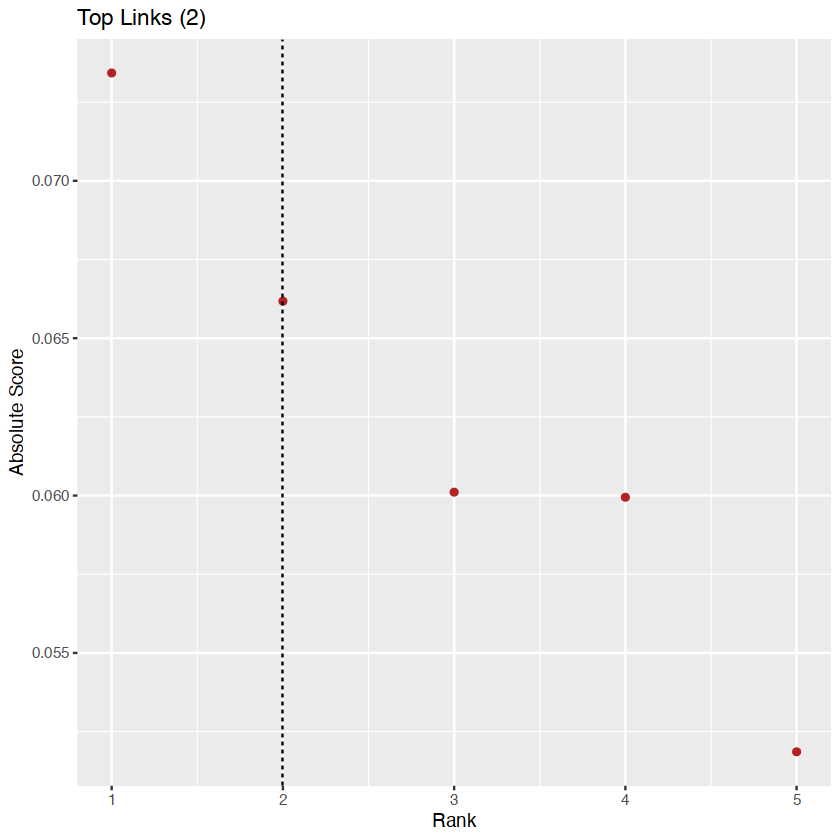

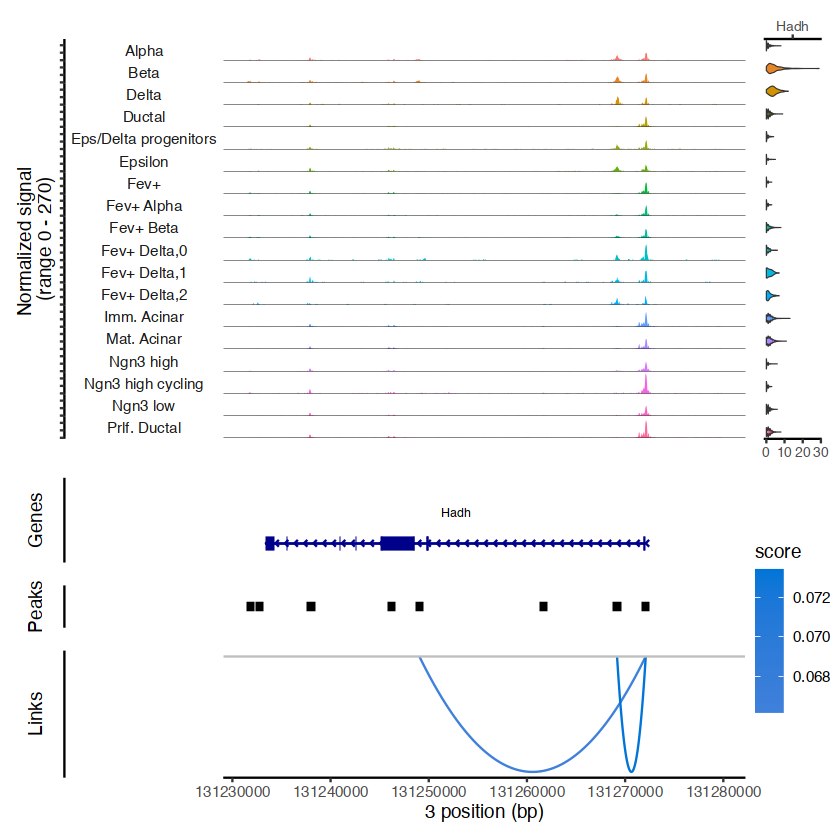

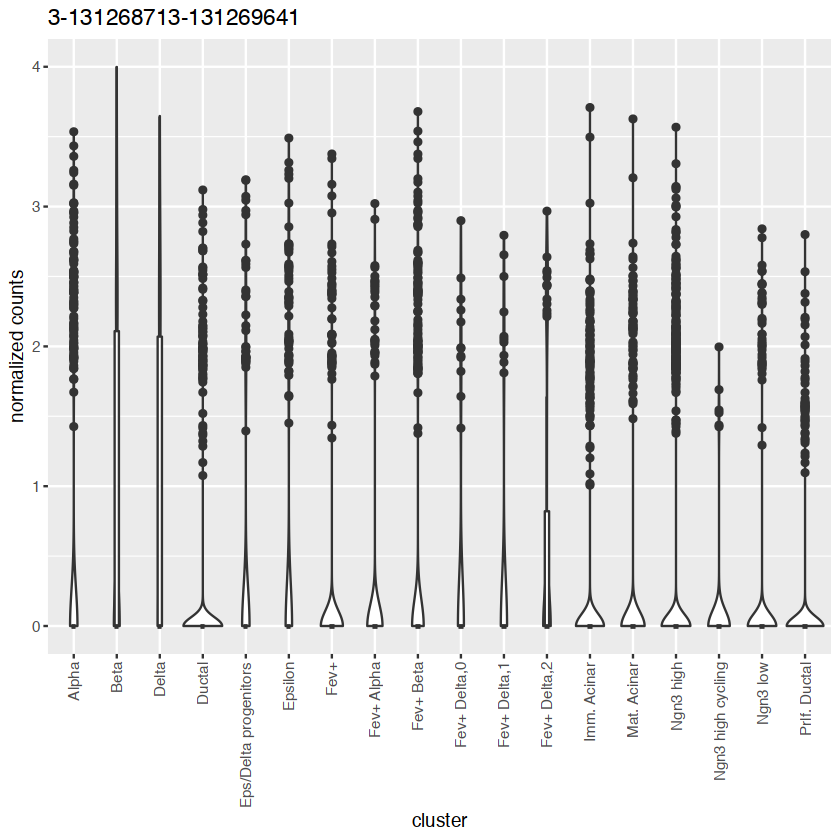

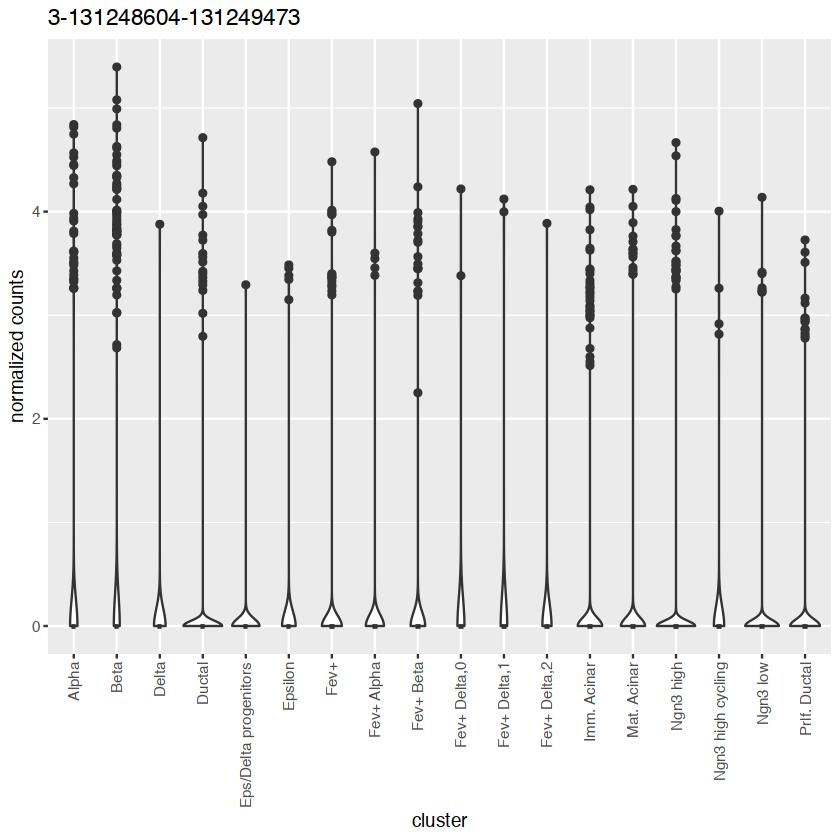

In [275]:
get_results(seurat, "split_fev_delta", "Hadh")

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



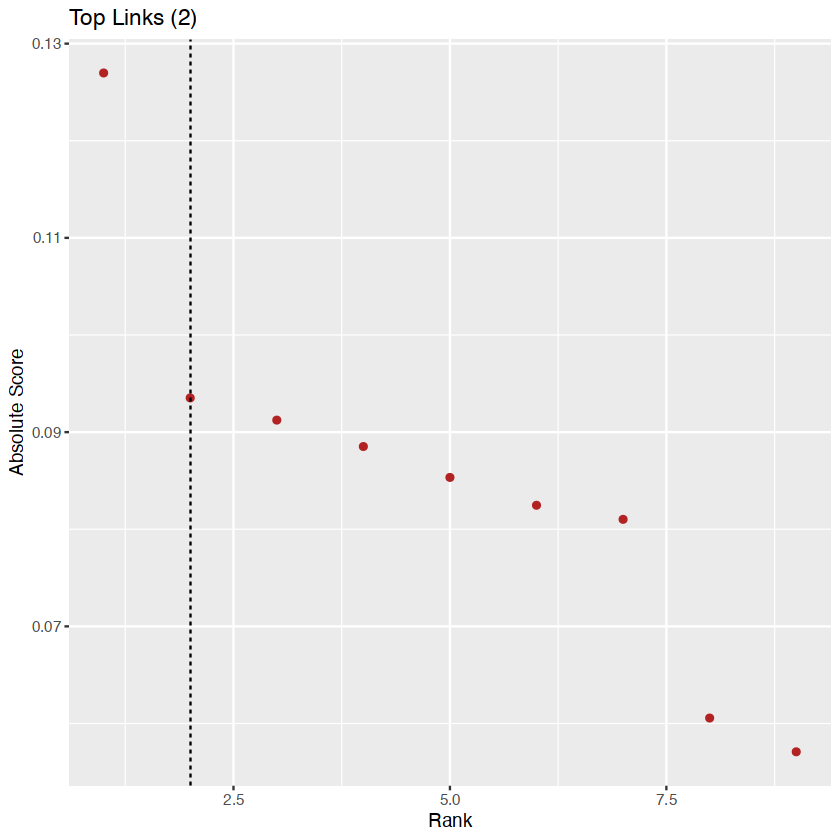

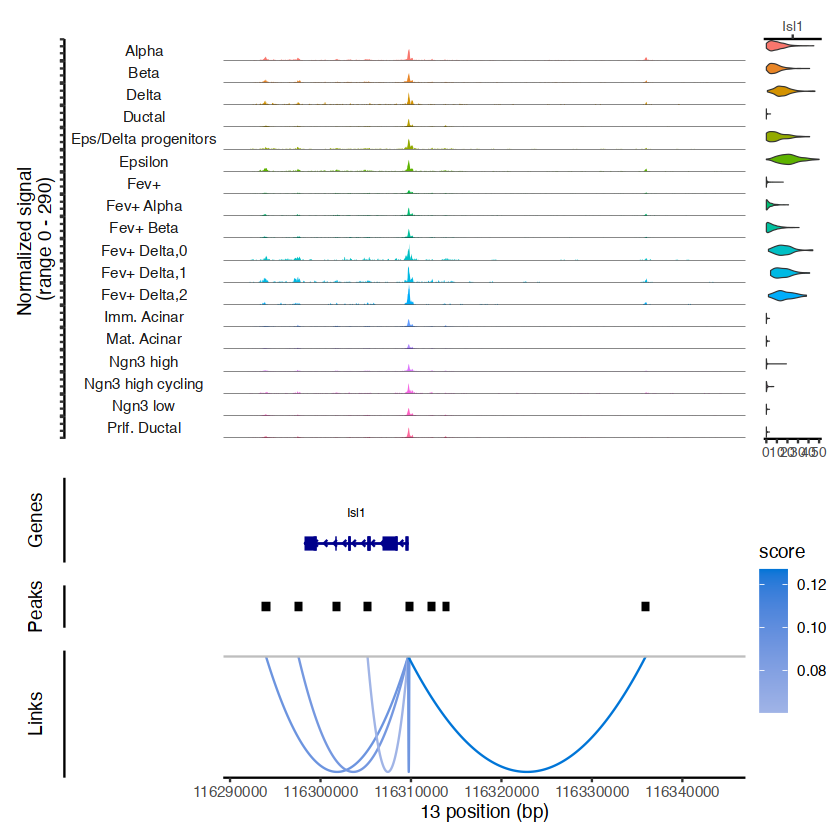

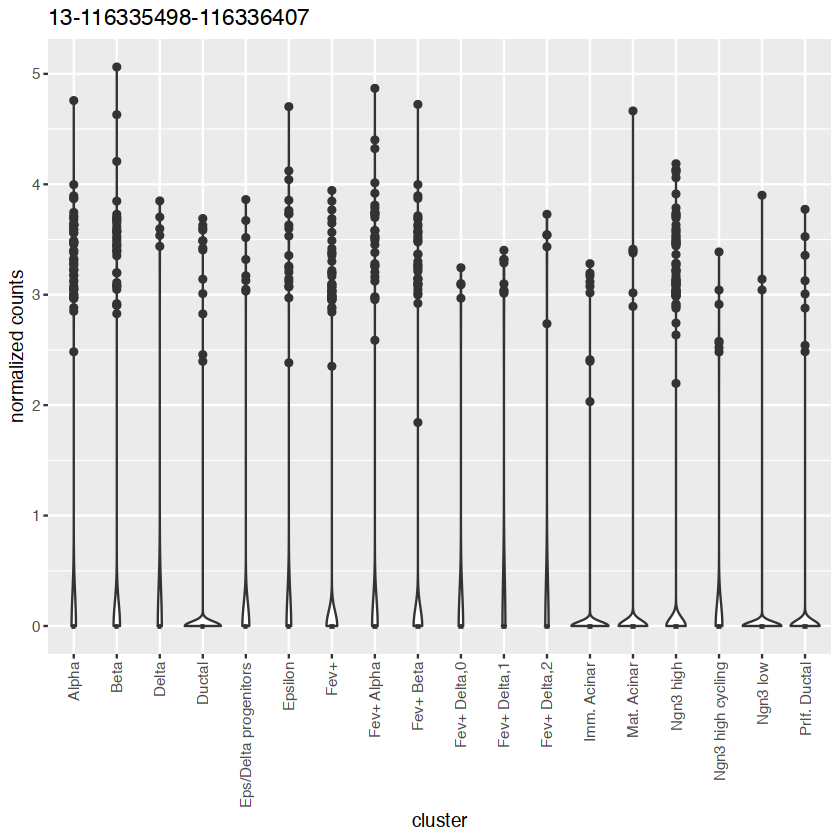

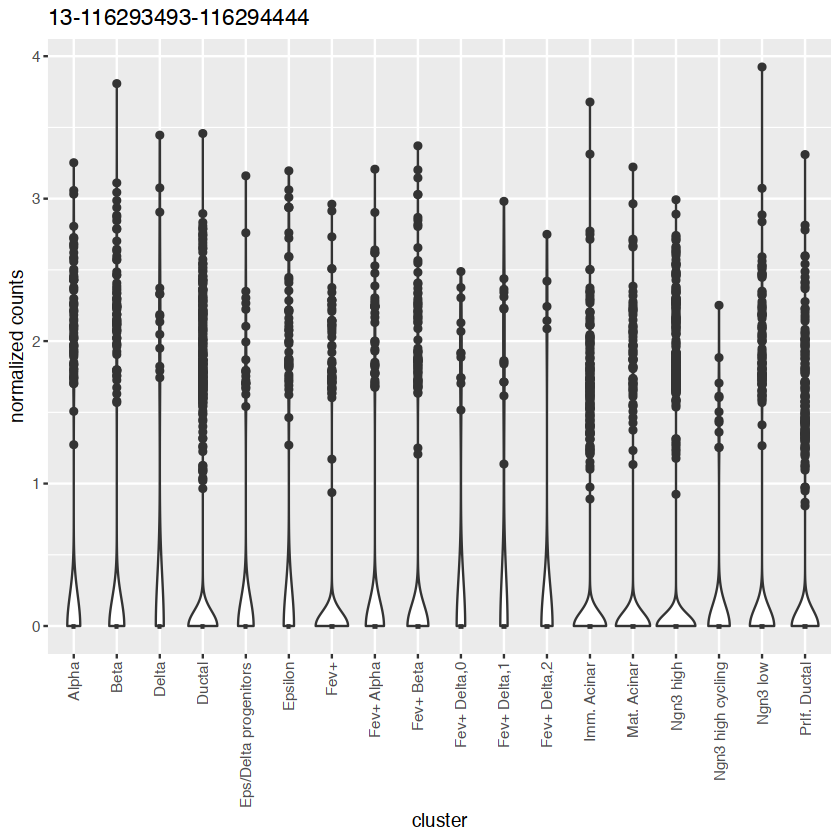

In [276]:
get_results(seurat, "split_fev_delta", "Isl1")

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



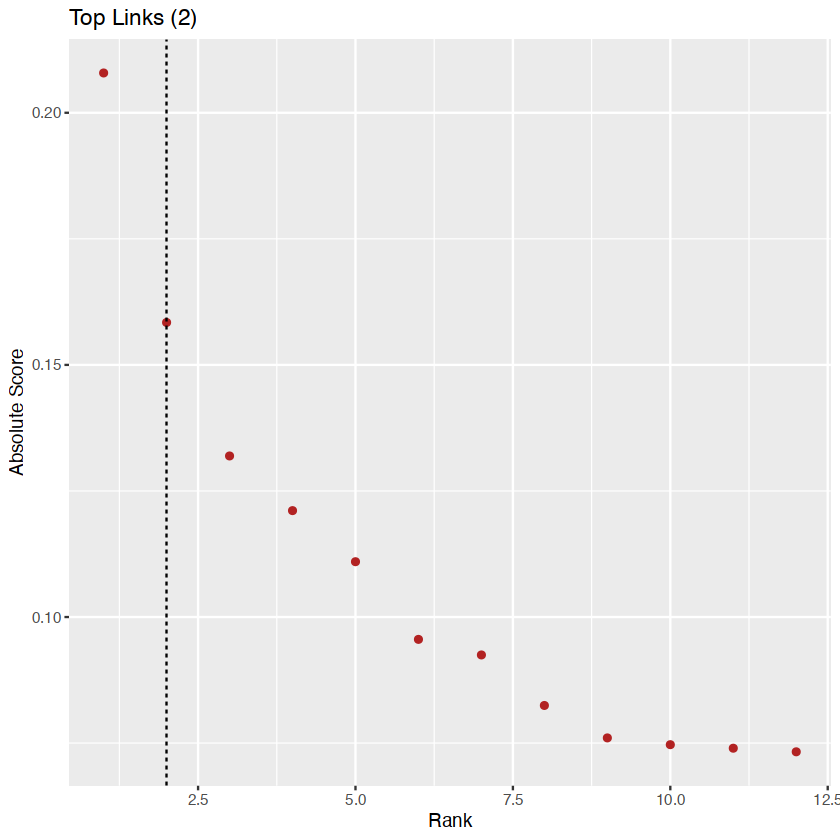

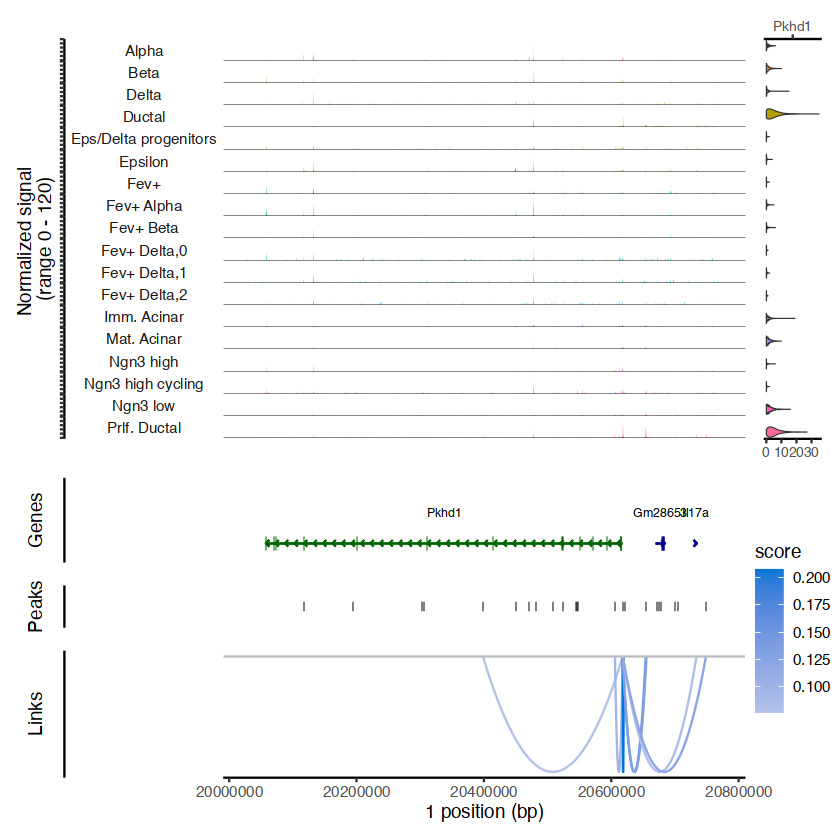

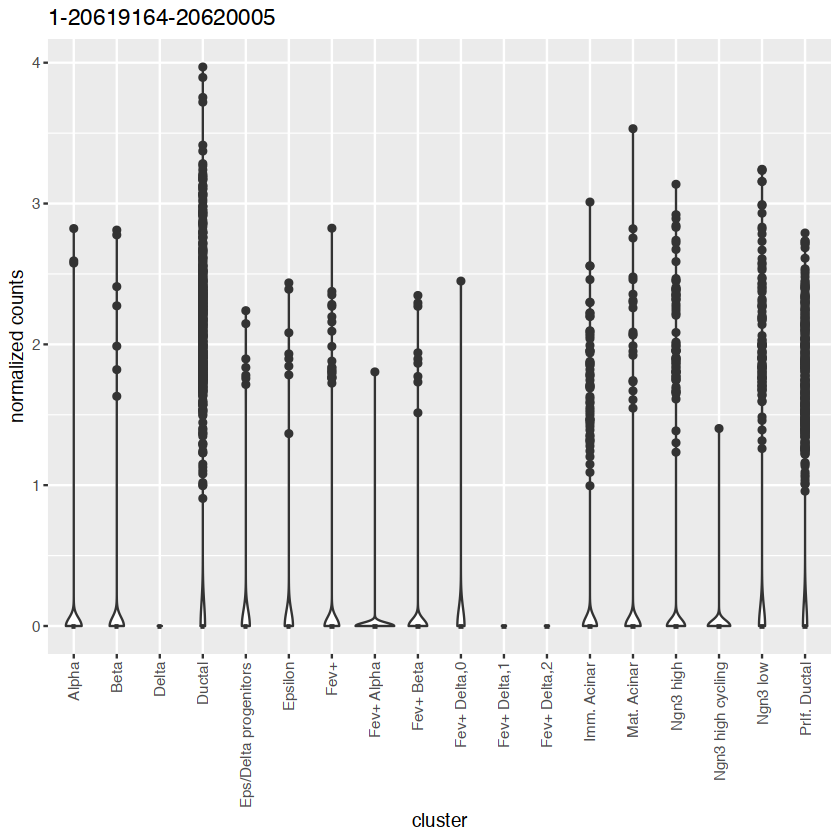

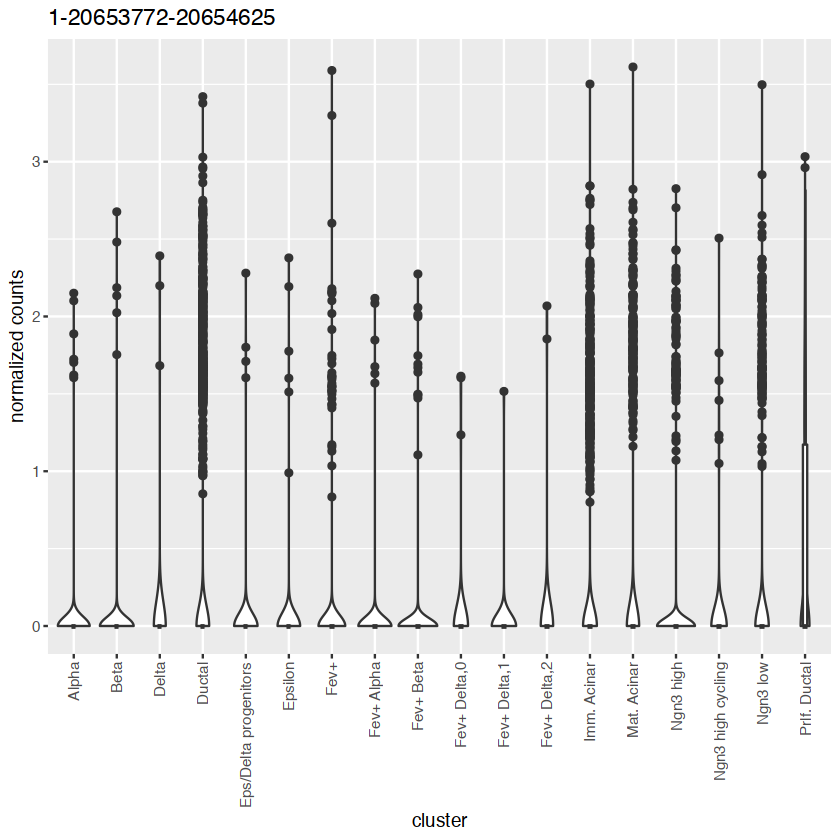

In [277]:
get_results(seurat, "split_fev_delta", "Pkhd1")

ERROR: Error in .new_IRanges_from_start_end(start, end): 'start' or 'end' cannot contain NAs


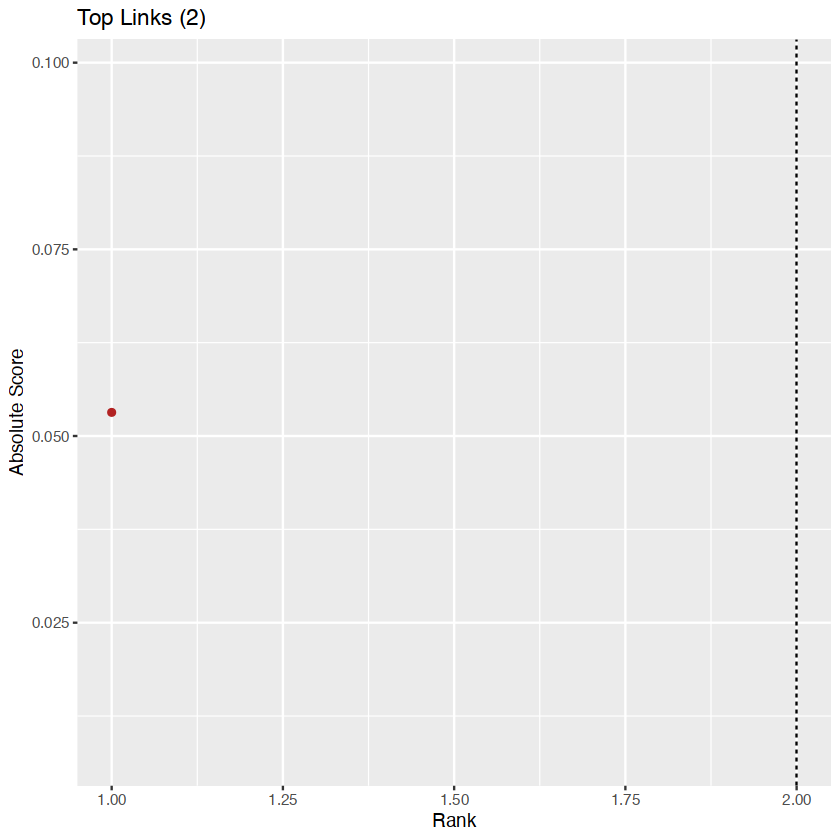

In [278]:
get_results(seurat, "split_fev_delta", "Map2k4")

In [279]:
get_results(seurat, "split_fev_delta", "Msi1")

[1] "No links detected for this gene"


ERROR: Error in `$<-.data.frame`(`*tmp*`, "rank", value = 1:0): Ersetzung hat 2 Zeilen, Daten haben 0


In [ ]:
get_results(seurat, "split_fev_delta", "Nefl")